In [2]:
import pandas as pd

df = pd.read_csv(r'..\data\raw\Mall_Customers.csv')

In [3]:
print(df.head(5))
print('-----------------')
print(df.info())
print('-----------------')
print(df.describe())
print('-----------------')
print('Amount of duplicates:',df.duplicated().sum())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
-----------------
       Customer

In [4]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

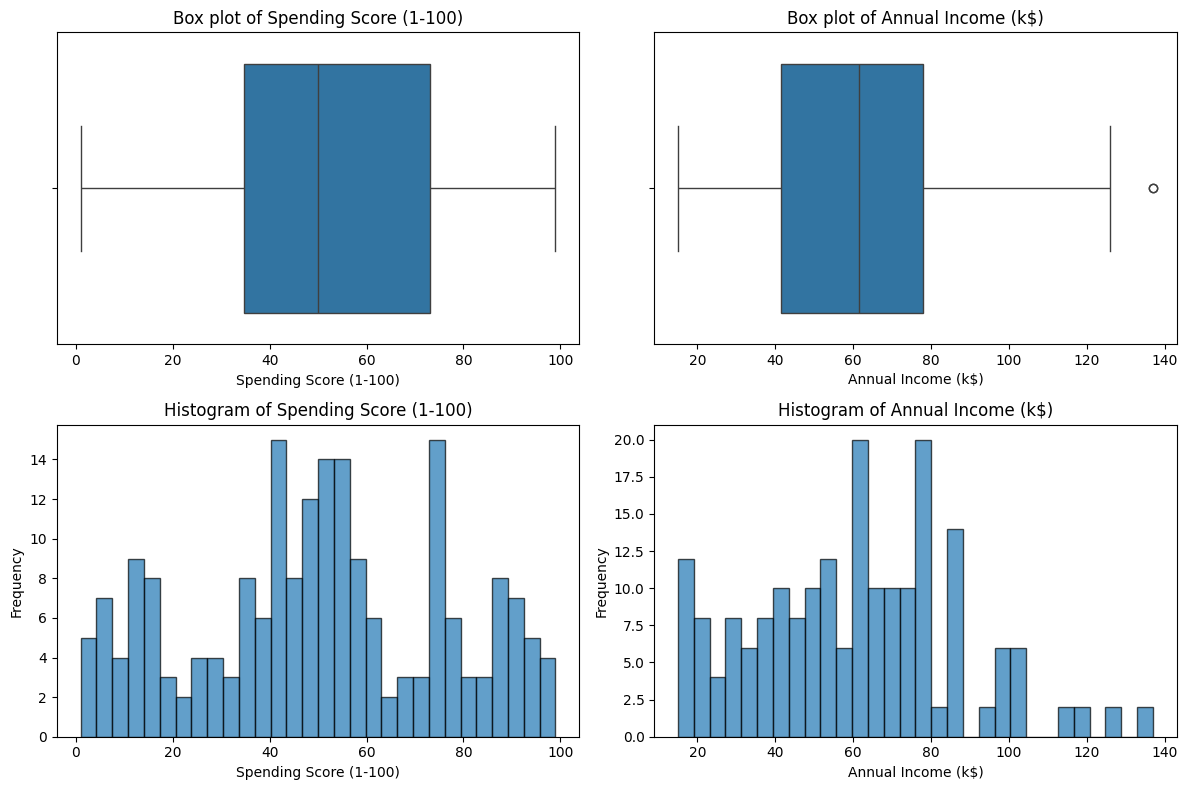

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2,2, figsize=(12,8))

column_1 = 'Spending Score (1-100)'
column_2 = 'Annual Income (k$)'

#Boxplots
sns.boxplot(x=df[column_1], ax=axes[0,0])
axes[0,0].set_title(f"Box plot of {column_1}")
sns.boxplot(x=df[column_2], ax=axes[0,1])
axes[0,1].set_title(f"Box plot of {column_2}")

#Histograms
axes[1,0].hist(df[column_1], bins=30, edgecolor="black", alpha=0.7)
axes[1,0].set_title(f"Histogram of {column_1}")
axes[1,0].set_xlabel(column_1)
axes[1,0].set_ylabel("Frequency")

axes[1,1].hist(df[column_2], bins=30, edgecolor="black", alpha=0.7)
axes[1,1].set_title(f"Histogram of {column_2}")
axes[1,1].set_xlabel(column_2)
axes[1,1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [7]:
df_encoded = pd.get_dummies(df, drop_first=True).astype(int)
print(df_encoded.head(5))

   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0           1   19                  15                      39            1
1           2   21                  15                      81            1
2           3   20                  16                       6            0
3           4   23                  16                      77            0
4           5   31                  17                      40            0


In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(df_encoded)
print("Normalized data:", X[:5,::])

Normalized data: [[0.         0.01923077 0.         0.3877551  1.        ]
 [0.00502513 0.05769231 0.         0.81632653 1.        ]
 [0.01005025 0.03846154 0.00819672 0.05102041 0.        ]
 [0.01507538 0.09615385 0.00819672 0.7755102  0.        ]
 [0.0201005  0.25       0.01639344 0.39795918 0.        ]]


In [39]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=42)

In [40]:
model.fit(X)

labels = model.labels_

centroids = model.cluster_centers_

In [14]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels)
print(score)

0.35104679968840213


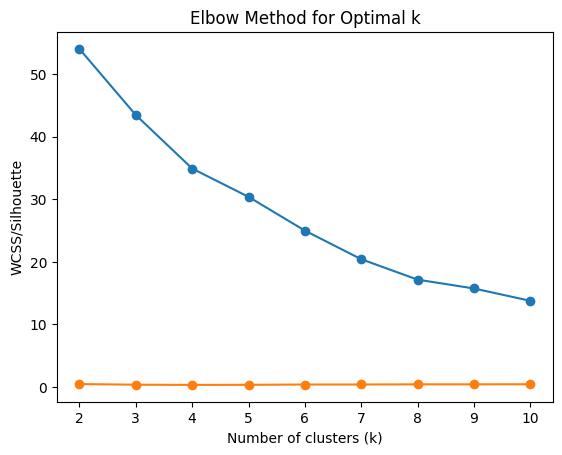

In [20]:
wcss = []
silhouette = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.fit_predict(X)))

plt.plot(range(2,11), wcss, marker='o')
plt.plot(range(2,11), silhouette, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS/Silhouette")
plt.title("Elbow Method for Optimal k")
plt.show()

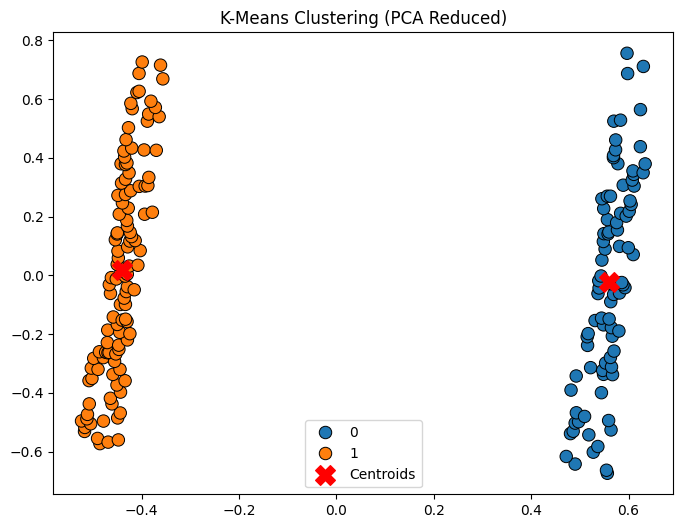

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:,1], hue=labels, palette="tab10", s=80, edgecolor='k')

centroids_pca = kmeans.cluster_centers_
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label="Centroids")

plt.title("K-Means Clustering (PCA Reduced)")
plt.legend()
plt.show()

In [33]:
centroid_df = pd.DataFrame(centroids, columns=df.columns)
print(centroid_df)

   CustomerID    Gender       Age  Annual Income (k$)  Spending Score (1-100)
0    0.518787  0.419362  0.387109            0.484810            1.000000e+00
1    0.485239  0.386504  0.362705            0.515579            4.440892e-16


In [41]:
df_encoded['Cluster'] = labels  # Assign cluster labels to the dataset

# Compute average feature values per cluster
cluster_summary = df_encoded.groupby("Cluster").mean()
print(cluster_summary)

         CustomerID        Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                                      
0        104.238636  39.806818           62.227273               48.511364   
1         97.562500  38.098214           59.250000               51.526786   

         Gender_Male  
Cluster               
0                1.0  
1                0.0  


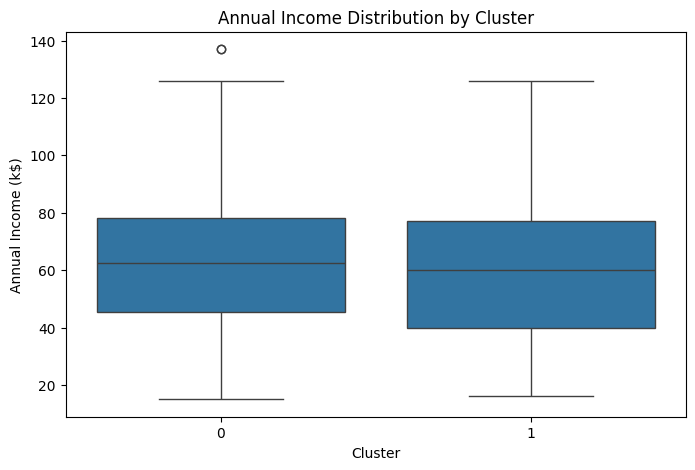

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of a feature across clusters
plt.figure(figsize=(8,5))
sns.boxplot(x=df_encoded["Cluster"], y=df_encoded["Annual Income (k$)"], data=df_encoded)
plt.title("Annual Income Distribution by Cluster")
plt.show()


In [45]:
pd.crosstab(df_encoded['Cluster'], df_encoded['Gender_Male'])


Gender_Male,0,1
Cluster,,
0,0,88
1,112,0


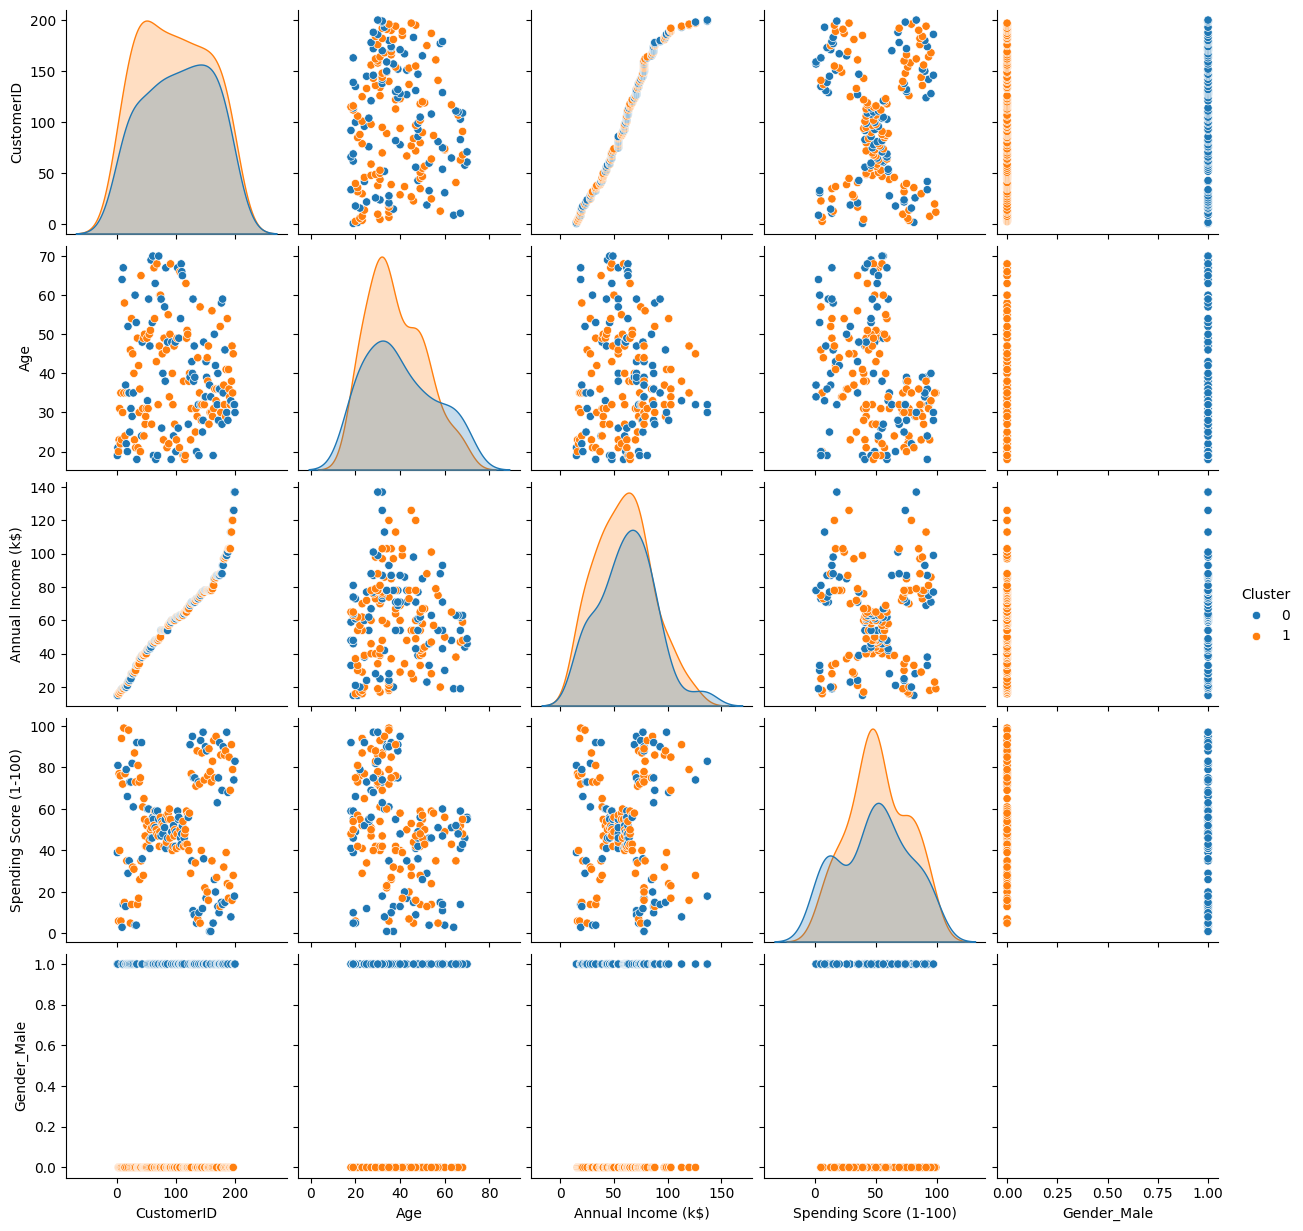

In [46]:
sns.pairplot(df_encoded, hue="Cluster", palette="tab10")
plt.show()


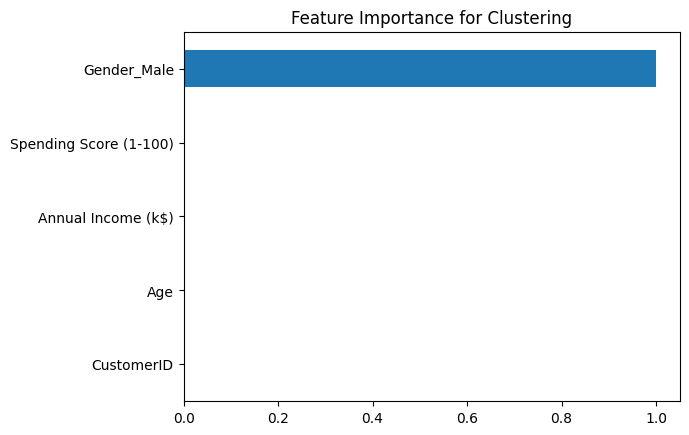

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X = df_encoded.drop("Cluster", axis=1)  # Features
y = df_encoded["Cluster"]  # Target (cluster labels)

model = DecisionTreeClassifier()
model.fit(X, y)

# Plot feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", title="Feature Importance for Clustering")
plt.show()


In [1]:
import sys
sys.path.append("../")

from src.data_preprocessing import data_preprocessing, data_scale


rename_map = {"Annual Income (k$)":"Annual Income", "Spending Score (1-100)":"Spending Score", "Gender_Male":"Gender"}
df = data_preprocessing(file_path="../data/raw/Mall_Customers.csv", one_hot_encode=True)
df = df.rename(columns=rename_map)

Colunas com valores remapeados em One_Hot_Encoding.
Pré-processamento bem sucedido.


In [2]:
data_scale(df)

Valores dimensionados utilizando o método MinMax.


array([[0.        , 0.01923077, 0.        , 0.3877551 , 1.        ],
       [0.00502513, 0.05769231, 0.        , 0.81632653, 1.        ],
       [0.01005025, 0.03846154, 0.00819672, 0.05102041, 0.        ],
       [0.01507538, 0.09615385, 0.00819672, 0.7755102 , 0.        ],
       [0.0201005 , 0.25      , 0.01639344, 0.39795918, 0.        ],
       [0.02512563, 0.07692308, 0.01639344, 0.76530612, 0.        ],
       [0.03015075, 0.32692308, 0.02459016, 0.05102041, 0.        ],
       [0.03517588, 0.09615385, 0.02459016, 0.94897959, 0.        ],
       [0.04020101, 0.88461538, 0.03278689, 0.02040816, 1.        ],
       [0.04522613, 0.23076923, 0.03278689, 0.7244898 , 0.        ],
       [0.05025126, 0.94230769, 0.03278689, 0.13265306, 1.        ],
       [0.05527638, 0.32692308, 0.03278689, 1.        , 0.        ],
       [0.06030151, 0.76923077, 0.04098361, 0.14285714, 0.        ],
       [0.06532663, 0.11538462, 0.04098361, 0.7755102 , 0.        ],
       [0.07035176, 0.36538462, 0.

In [3]:
df = data_preprocessing(file_path="../data/raw/Wholesome_Customer.csv")
print(df.describe())


Pré-processamento bem sucedido.
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742

In [4]:
df.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
